In [1]:
import pandas as pd
import numpy as np
import time 

import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [3]:
train.global_category.value_counts()

CAMERA             136665
AUDIO               13492
HOME AUTOMATION     10776
Name: global_category, dtype: int64

In [4]:
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
train = train.drop(columns = ['global_category','interaction_type','command'])
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
test = test.drop(columns = ['global_category','interaction_type','command'])

In [5]:
x_train, y_train = train.drop(columns=['device']), train['device']
x_test, y_test = test.drop(columns=['device']), test['device']

# Normalización de los datos:

In [6]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(x_train.select_dtypes(include=['float64', 'int64']))
X_test_scaled = scaler.transform(x_test.select_dtypes(include=['float64', 'int64']))

In [10]:
clf = MLPClassifier()

In [11]:
start = time.time()
clf.fit(X_train_scaled, y_train)
stop = time.time()

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [12]:
print(f'MLP execution time: {stop-start: }s')
print(f'Train accuracy : {clf.score(X_train_scaled, y_train): .3f}')
print(f'Test accuracy : {clf.score(X_test_scaled, y_test): .3f}')

MLP execution time:  134.0117118358612s
Train accuracy :  0.984
Test accuracy :  0.921


In [9]:
clf.get_params

<bound method BaseEstimator.get_params of MLPClassifier()>

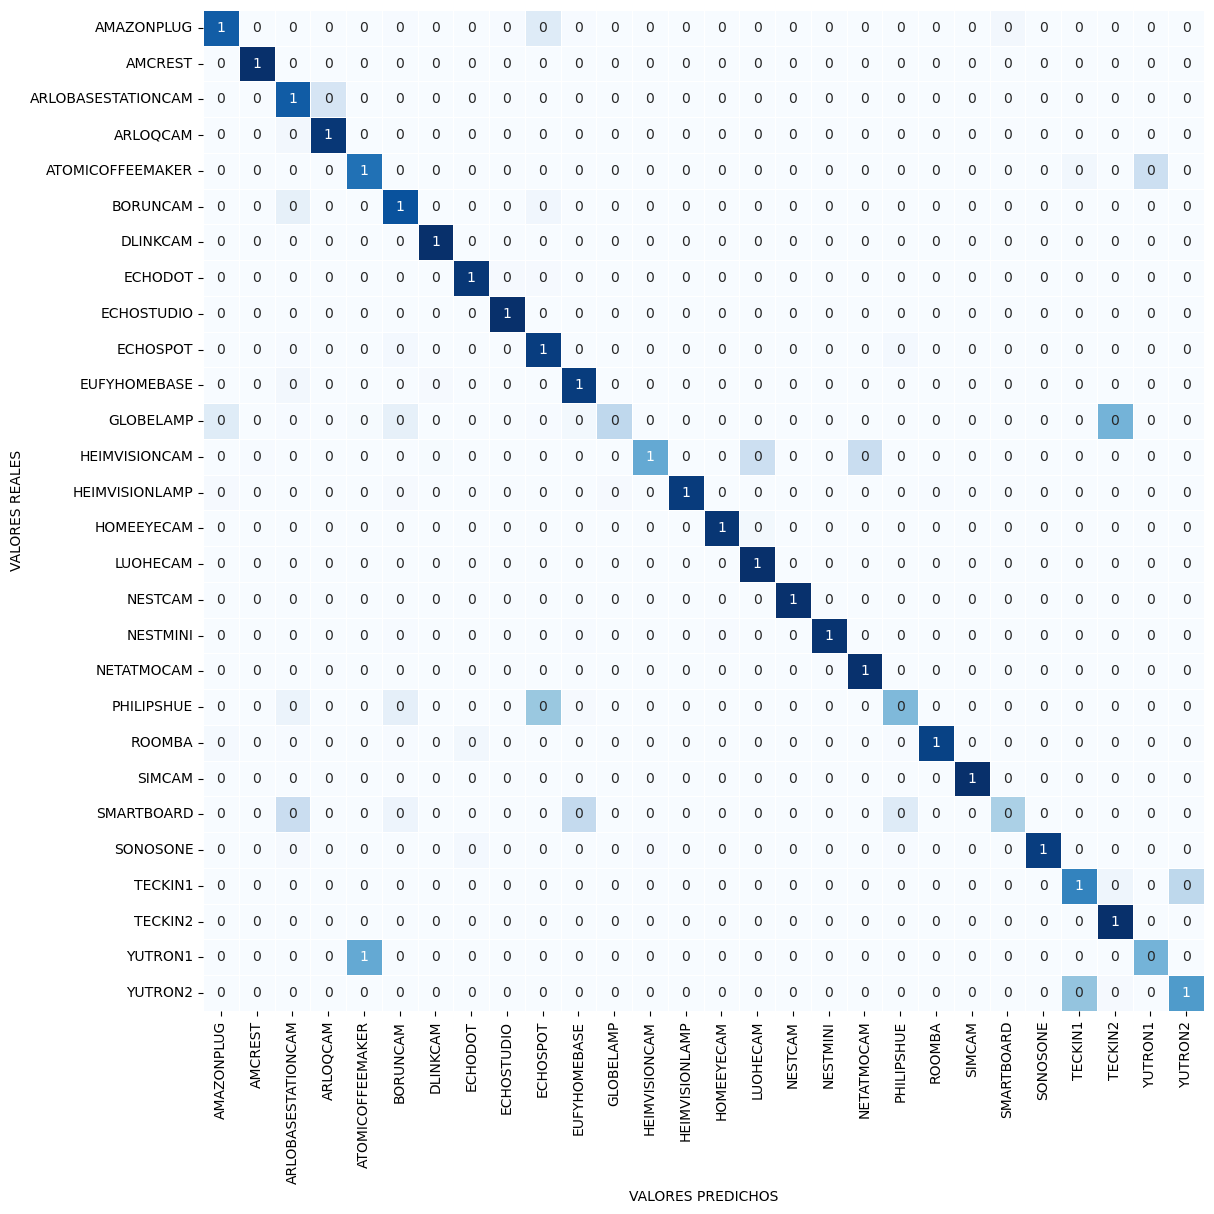

In [13]:
y_pred = clf.predict(X_test_scaled)
cm = metrics.confusion_matrix(y_test, y_pred)

cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm / cm.sum(axis=1, keepdims=True)

class_names = ['AMAZONPLUG','AMCREST','ARLOBASESTATIONCAM', 'ARLOQCAM', 'ATOMICOFFEEMAKER', 'BORUNCAM',
               'DLINKCAM', 'ECHODOT', 'ECHOSTUDIO', 'ECHOSPOT', 'EUFYHOMEBASE', 'GLOBELAMP', 'HEIMVISIONCAM', 
               'HEIMVISIONLAMP', 'HOMEEYECAM', 'LUOHECAM', 'NESTCAM', 'NESTMINI','NETATMOCAM', 'PHILIPSHUE',
               'ROOMBA', 'SIMCAM', 'SMARTBOARD', 'SONOSONE', 'TECKIN1','TECKIN2','YUTRON1', 'YUTRON2']


sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(13, 13)

plt.ylabel('VALORES REALES')
plt.xlabel('VALORES PREDICHOS')
plt.show()

In [17]:
print(metrics.classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

        amazonplug       0.91      0.87      0.89       172
           amcrest       0.98      1.00      0.99      4027
arlobasestationcam       0.95      0.80      0.87      6161
          arloqcam       0.84      0.99      0.91      6555
  atomicoffeemaker       0.73      0.84      0.78       127
          boruncam       0.82      0.86      0.84       568
          dlinkcam       0.96      0.99      0.98      2850
           echodot       0.95      0.94      0.95       810
          echospot       0.97      1.00      0.98      1052
        echostudio       0.84      0.92      0.88       877
      eufyhomebase       0.99      0.96      0.98      3954
         globelamp       0.91      0.26      0.41       195
     heimvisioncam       0.99      0.64      0.78      6201
    heimvisionlamp       0.99      0.95      0.97       153
        homeeyecam       1.00      0.99      0.99      9937
          luohecam       0.80      1.00

# RandomSearchCV (NO MUY EFECTIVO):

In [77]:
param_grid = {'hidden_layer_sizes': [5, 10, 15, (5,5), (5,10), (50,25), (75,50), (75,50,25), (100,75),(150,100), (100,75,50)], 
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              'max_iter': [int(x) for x in np.linspace(start=200, stop=1000, num=800)]}

MLP_RandomGrid = RandomizedSearchCV(estimator = clf,
                                    param_distributions = param_grid, 
                                    cv = 5, verbose=2)

start = time.time()
MLP_RandomGrid.fit(X_train_scaled, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END activation=logistic, hidden_layer_sizes=15, learning_rate=adaptive, max_iter=404, solver=adam; total time=   9.1s
[CV] END activation=logistic, hidden_layer_sizes=15, learning_rate=adaptive, max_iter=404, solver=adam; total time=   9.5s
[CV] END activation=logistic, hidden_layer_sizes=15, learning_rate=adaptive, max_iter=404, solver=adam; total time=  11.0s
[CV] END activation=logistic, hidden_layer_sizes=15, learning_rate=adaptive, max_iter=404, solver=adam; total time=  10.6s
[CV] END activation=logistic, hidden_layer_sizes=15, learning_rate=adaptive, max_iter=404, solver=adam; total time=   6.8s
[CV] END activation=tanh, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=811, solver=sgd; total time=  12.9s
[CV] END activation=tanh, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=811, solver=sgd; total time=  19.0s
[CV] END activation=tanh, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max

Stochastic Optimizer: Maximum iterations (395) reached and the optimization hasn't converged yet.


[CV] END activation=logistic, hidden_layer_sizes=(150, 100), learning_rate=adaptive, max_iter=395, solver=sgd; total time= 1.1min


Stochastic Optimizer: Maximum iterations (395) reached and the optimization hasn't converged yet.


[CV] END activation=logistic, hidden_layer_sizes=(150, 100), learning_rate=adaptive, max_iter=395, solver=sgd; total time= 1.1min


Stochastic Optimizer: Maximum iterations (395) reached and the optimization hasn't converged yet.


[CV] END activation=logistic, hidden_layer_sizes=(150, 100), learning_rate=adaptive, max_iter=395, solver=sgd; total time= 1.1min


Stochastic Optimizer: Maximum iterations (395) reached and the optimization hasn't converged yet.


[CV] END activation=logistic, hidden_layer_sizes=(150, 100), learning_rate=adaptive, max_iter=395, solver=sgd; total time= 1.2min
[CV] END activation=logistic, hidden_layer_sizes=(75, 50), learning_rate=invscaling, max_iter=556, solver=sgd; total time=   1.2s
[CV] END activation=logistic, hidden_layer_sizes=(75, 50), learning_rate=invscaling, max_iter=556, solver=sgd; total time=   1.2s
[CV] END activation=logistic, hidden_layer_sizes=(75, 50), learning_rate=invscaling, max_iter=556, solver=sgd; total time=   1.2s
[CV] END activation=logistic, hidden_layer_sizes=(75, 50), learning_rate=invscaling, max_iter=556, solver=sgd; total time=   1.2s
[CV] END activation=logistic, hidden_layer_sizes=(75, 50), learning_rate=invscaling, max_iter=556, solver=sgd; total time=   1.2s
[CV] END activation=identity, hidden_layer_sizes=10, learning_rate=constant, max_iter=863, solver=adam; total time=   4.5s
[CV] END activation=identity, hidden_layer_sizes=10, learning_rate=constant, max_iter=863, solver

In [78]:
print('Score: ', MLP_RandomGrid.best_score_)
print('Parameters: ', MLP_RandomGrid.best_params_)

Score:  0.9617486338797813
Parameters:  {'solver': 'adam', 'max_iter': 231, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (75, 50), 'activation': 'logistic'}


#  Ajuste Manual:

In [8]:
clf2 = MLPClassifier(hidden_layer_sizes=(100,),
                    activation='identity', 
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter = 200,
                    learning_rate_init=0.001)

#alpha -> Para la regulación del sobreajuste
#solver = sgd tarda más 
#600 iter

start = time.time()
clf2.fit(X_train_scaled, y_train)
stop = time.time()

In [9]:
print(f"MLP training time: {stop - start}s")
print(f'Train accuracy : {clf2.score(X_train_scaled, y_train): .3f}')
print(f'Test accuracy : {clf2.score(X_test_scaled, y_test): .3f}')

MLP training time: 53.13767623901367s
Train accuracy :  0.890
Test accuracy :  0.876


In [15]:
y_pred = clf2.predict(X_test_scaled)
cm = metrics.confusion_matrix(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
normalized_matrix = cm / cm.sum(axis=1, keepdims=True)

class_names = ['AMAZONPLUG','AMCREST','ARLOBASESTATIONCAM', 'ARLOQCAM', 'ATOMICOFFEEMAKER', 'BORUNCAM',
               'DLINKCAM', 'ECHODOT', 'ECHOSTUDIO', 'ECHOSPOT', 'EUFYHOMEBASE', 'GLOBELAMP', 'HEIMVISIONCAM', 
               'HEIMVISIONLAMP', 'HOMEEYECAM', 'LUOHECAM', 'NESTCAM', 'NESTMINI','NETATMOCAM', 'PHILIPSHUE',
               'ROOMBA', 'SIMCAM', 'SMARTBOARD', 'SONOSONE', 'TECKIN1','TECKIN2','YUTRON1', 'YUTRON2']


sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(13, 13)

plt.ylabel('VALORES REALES')
plt.xlabel('VALORES PREDICHOS')
plt.show()

NotFittedError: This MLPClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
print(metrics.classification_report(y_test, y_pred_RF))